In [2]:
import torch_utils as tu
import experiment_utils as eu
import torch
import torch.nn as nn
import datasets
from PIL import Image
import numpy as np
from torchvision import transforms

In [3]:
data = datasets.load_dataset("ylecun/mnist")
data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [4]:
def transform(samples):
    transform = transforms.Compose(
        [
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize((0.1309,), (0.2893,)),
        ]
    )

    samples["image"] = [transform(img) for img in samples["image"]]
    return samples

In [5]:
train_data = data["train"]
test_data = data["test"]
train_data.set_transform(transform)
test_data.set_transform(transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [6]:
sample  = next(iter(train_loader))
sample["image"].shape

torch.Size([64, 1, 32, 32])

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 2, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.conv4 = nn.Conv2d(128, 128, 3, 2, 1)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc_mu = nn.Linear(512, 512)
        self.fc_logvar = nn.Linear(512, 512)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(512, 128 * 8 * 8)
        self.conv1 = nn.ConvTranspose2d(128, 128, 3, 2, 1, 1)
        self.conv2 = nn.ConvTranspose2d(128, 64, 3, 1, 1, 0)
        self.conv3 = nn.ConvTranspose2d(64, 32, 3, 2, 1, 1)
        self.conv4 = nn.ConvTranspose2d(32, 1, 3, 1, 1, 0)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = x.view(-1, 128, 8, 8)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.conv4(x)
        return x

In [9]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.mu = nn.Parameter(torch.zeros(512))
        self.logvar = nn.Parameter(torch.zeros(512))

    def forward(self, sample):
        x = sample["image"]
        mu, lvar = self.encoder(x)
        eps = torch.randn_like(mu)
        x = mu + self.mu + torch.exp(lvar / 2) * torch.exp(self.logvar / 2) * eps
        x = self.decoder(x)

        y = sample["image"]
        kld = 0.5 * torch.mean(mu**2 + torch.exp(lvar) - lvar - 1)
        rec = nn.functional.mse_loss(x, y)
        loss = rec + kld
        return {"output": x, "loss": loss, "accuracy": torch.zeros(1)}


model = Model()

In [10]:
lr = 1e-3
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [11]:
logger = eu.Logger("../.logs")
logger.start_experiment()

In [12]:
runner = tu.Runner(
    model=model,
    optimizer=optimizer,
    device="cuda",
    logger=logger,
)

In [13]:
runner.train(
    train_loader=train_loader,
    val_loader=test_loader,
    steps=1000,
    val_steps=100,
    log_steps=10,
)

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Step: 100/1000 Train loss: 0.477688193321228, Val loss: 0.458214386844635
Step: 200/1000 Train loss: 0.3857068121433258, Val loss: 0.35638864974975587
Step: 300/1000 Train loss: 0.3184188902378082, Val loss: 0.3071869176387787
Step: 400/1000 Train loss: 0.27713721990585327, Val loss: 0.2853215562820435
Step: 500/1000 Train loss: 0.24651208519935608, Val loss: 0.25603211517333985
Step: 600/1000 Train loss: 0.24506664276123047, Val loss: 0.244179274225235
Step: 700/1000 Train loss: 0.23971839249134064, Val loss: 0.23134334135055543
Step: 800/1000 Train loss: 0.21318884193897247, Val loss: 0.21721650280952454
Step: 900/1000 Train loss: 0.20461829006671906, Val loss: 0.21097006716728212
Step: 1000/1000 Train loss: 0.18738850951194763, Val loss: 0.20127779717445374


0.20159672584533692

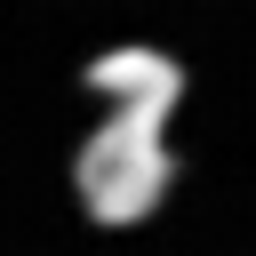

In [14]:
x = torch.randn(1, 512).to("cuda") * torch.exp(model.logvar / 2) + model.mu
x = model.decoder(x)
x = x[0].detach().cpu().numpy()
x = (x - x.min()) / (x.max() - x.min())
x = Image.fromarray((x * 255).astype(np.uint8).squeeze()).resize((256, 256))
display(x)

7


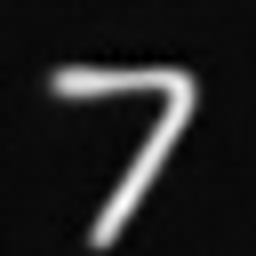

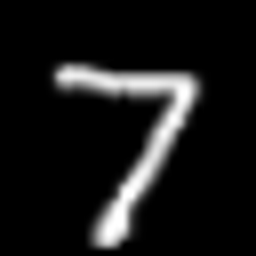

2


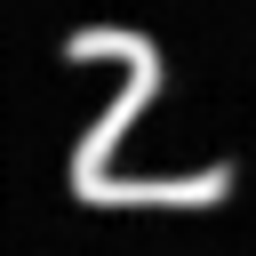

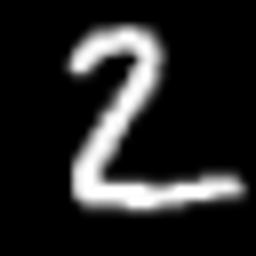

1


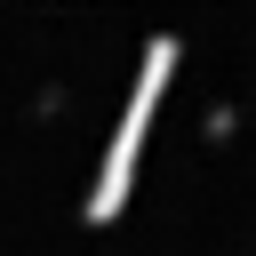

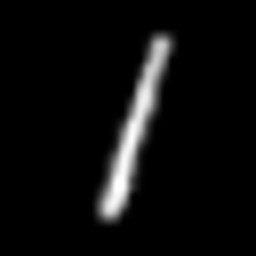

0


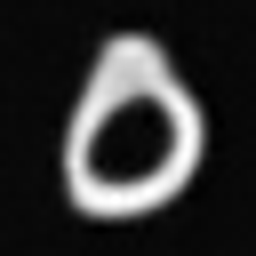

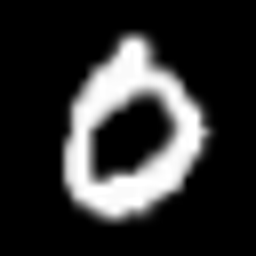

4


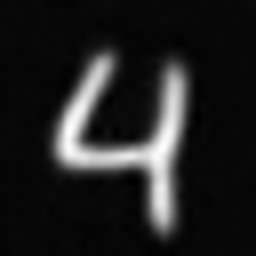

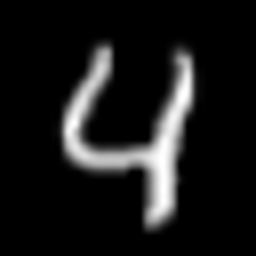

1


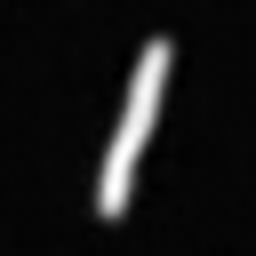

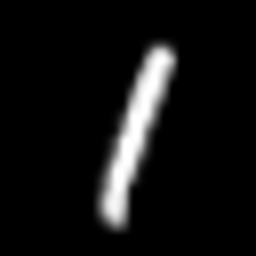

4


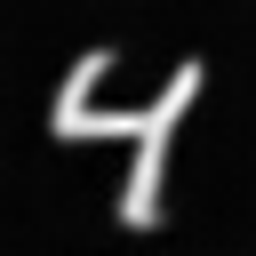

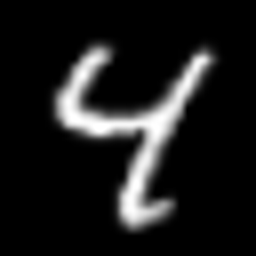

9


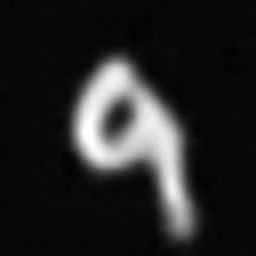

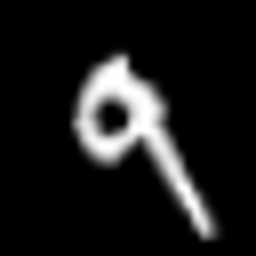

5


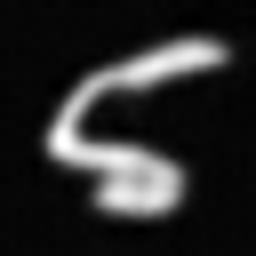

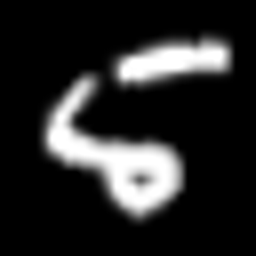

9


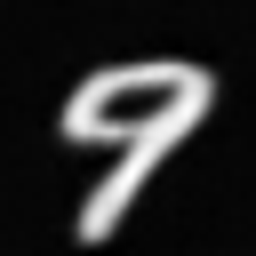

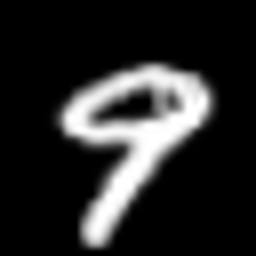

In [15]:
sample = next(iter(test_loader))
for i in range(10):
    with torch.no_grad():
        sample = {k: v.to("cuda") for k, v in sample.items()}
        output = model(sample)
    x = output["output"][i].cpu().numpy()
    y = sample["image"][i].cpu().numpy()
    x = (x - x.min()) / (x.max() - x.min())
    y = (y - y.min()) / (y.max() - y.min())
    x = Image.fromarray((x * 255).astype(np.uint8).squeeze()).resize((256, 256))
    y = Image.fromarray((y * 255).astype(np.uint8).squeeze()).resize((256, 256))
    print(sample["label"][i].item())
    display(x)
    display(y)